# Prediction of New-Onset Atrial Fibrillation Using Routinely Reported 12-Lead ECG Variables and Electronic Health Data

In [2]:
# ------------------------------
# Imports
# ------------------------------
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, recall_score, f1_score, confusion_matrix,
    precision_recall_curve, average_precision_score, PrecisionRecallDisplay
)

from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer

In [3]:
# ------------------------------
# Load Dataset
# ------------------------------
data_raw = pd.read_excel("synthetic_data_stats_competition_2025.xlsx")
data_raw.drop(columns=["patient_id"], inplace=True)

In [4]:
def drop_missing_ECG(df):
    missing_idx = df.index[
        (df['ecg_resting_hr'].isnull()) &
        (df['ecg_resting_pr'].isnull()) &
        (df['ecg_resting_qrs'].isnull()) &
        (df['ecg_resting_qtc'].isnull())
    ]
    return df.drop(missing_idx)
data_raw = drop_missing_ECG(data_raw)

In [5]:
data_raw["demographics_birth_sex"] = data_raw["demographics_birth_sex"].replace({1: 0, 2: 1})
data_raw["demographics_birth_sex"].head()

0    1
1    0
2    0
3    0
4    1
Name: demographics_birth_sex, dtype: int64

In [6]:
leakage_cols = [
    # Cardiac Risk:
    "hypertension_icd10", "diabetes_combined", "dyslipidemia_combined",
    # Disease - CV:
    "dcm_icd10", "hcm_icd10", "aortic_aneurysm_icd10",
    # Disease - Non-CV:
    "pulmonary_htn_icd10", "amyloid_icd10", "copd_icd10",
    "obstructive _sleep_apnea_icd10", "hyperthyroid_icd10",
    "hypothyroid_icd10", "rheumatoid_arthritis_icd10", "sle_icd10",
    "sarcoid_icd10", "cancer_any_icd10",
    # ECG:
    "ecg_resting_afib", "ecg_resting_aflutter",
    # Laboratory:
    "hgb_peri", "hct_peri", "rdw_peri", "wbc_peri", "plt_peri", "inr_peri",
    "ptt_peri", "esr_peri", "crp_high_sensitive_peri", "albumin_peri",
    "alkaline_phophatase_peri", "alanine_transaminase_peri",
    "aspartate_transaminase_peri", "bilirubin_total_peri", "bilirubin_direct_peri",
    "urea_peri", "creatinine_peri", "urine_alb_cr_ratio_peri", "sodium_peri",
    "potassium_peri", "chloride_peri", "ck_peri", "troponin_t_hs_peri_highest",
    "NTproBNP_peri_highest", "glucose_fasting_peri_highest",
    "glucose_random_peri_highest", "hga1c_peri_highest", "tchol_peri_highest",
    "ldl_peri_highest", "hdl_peri_lowest", "tg_peri_highest", "iron_peri",
    "tibc_peri", "ferritin_peri", "tsh_peri",
    # Medications:
    "anti_platelet_oral_non_asa_any_peri", "anti_coagulant_oral_any_peri", "nitrates_any_peri",
    "ranolazine_peri", "acei_peri", "arb_peri", "arni_entresto_peri", "beta_blocker_any_peri",
    "ivabradine_peri", "ccb_dihydro_peri", "ccb_non_dihydro_peri", "diuretic_loop_peri",
    "diuretic_thiazide_peri", "diuretic_low_ceiling_non_thiazide_peri", "diuretic_metolazone_peri",
    "diuretic_indapamide_peri", "diuretic_mra_peri", "diuretic_vasopressin_antagonist_peri",
    "anti_arrhythmic_any_peri", "anti_arrhythmic_amiodarone_peri", "anti_arrhythmic_disopyramide_peri",
    "digoxin_peri", "amyloid_therapeutics_tafamidis_peri", "amyloid_therapeutics_diflunisal_peri",
    "amyloid_therapeutics_patisiran_peri", "amyloid_therapeutics_inotersen_peri",
    "lipid_statin_peri", "lipid_fibrate_peri", "lipid_ezetimibe_peri", "lipid_PCKSK9_peri",
    "lipid_other_peri", "glucose_insulin_peri", "glucose_glp_1_agonsist_peri",
    "glucose_ohg_biguanide_peri", "glucose_ohg_alphagluc_peri", "glucose_ohg_dpp_4_peri",
    "glucose_ohg_sglt_2_peri", "glucose_ohg_thiazolidine_peri", "glucose_ohg_repaglinide_peri",
    "glucose_ohg_sulfonylurea_peri", "glucose_ohg_other_peri", "smoking_cessation_oral_peri",
    "smoking_cessation_nicotine_replacement_peri",
    # Future outcomes:
    "time_to_outcome_afib_aflutter_new_post", "outcome_all_cause_death",
    "time_to_outcome_all_cause_death", "follow_up_duration"
]
data_raw.drop(columns=leakage_cols, inplace=True)

In [7]:
data_raw.shape

(106430, 37)

In [8]:
# --------------------------
# Train-Test Split
# --------------------------
y = data_raw["outcome_afib_aflutter_new_post"]
X = data_raw.drop(columns=["outcome_afib_aflutter_new_post"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=26
)

In [9]:
# ------------------------------
# Imputation + Scaling
# ------------------------------
mice_imputer = IterativeImputer(random_state=26)
scaler = StandardScaler()

X_train_imputed = pd.DataFrame(mice_imputer.fit_transform(X_train),
                               columns=X_train.columns,
                               index=X_train.index)
X_test_imputed = pd.DataFrame(mice_imputer.transform(X_test),
                              columns=X_test.columns,
                              index=X_test.index)

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed),
                              columns=X_train.columns,
                              index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imputed),
                             columns=X_test.columns,
                             index=X_test.index)

In [10]:
# ------------------------------
# Bayesian Hyperparameter Tuning
# ------------------------------
scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=26)

param_space = {
    "n_estimators": Integer(100, 600),
    "learning_rate": Real(0.005, 0.2, prior='log-uniform'),
    "max_depth": Integer(3, 10),
    "min_child_weight": Integer(1, 6),
    "gamma": Real(0, 0.5),
    "reg_alpha": Real(0, 1),
    "reg_lambda": Real(0, 10),
    "subsample": Real(0.5, 1.0),
    "colsample_bytree": Real(0.5, 1.0)
}

base_estimator = XGBClassifier(
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    tree_method='hist',
    n_jobs=-1
)

bayes_search_xgb = BayesSearchCV(
    estimator=base_estimator,
    search_spaces=param_space,
    n_iter=250,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=26,
    refit=True
)

bayes_search_xgb.fit(X_train_scaled, y_train)

best_xgb = bayes_search_xgb.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [11]:
# print the best hyper‑parameters
print("Best parameters found:")
for param, val in bayes_search_xgb.best_params_.items():
    print(f"  • {param}: {val}")

Best parameters found:
  • colsample_bytree: 0.5
  • gamma: 0.5
  • learning_rate: 0.019813890460327478
  • max_depth: 6
  • min_child_weight: 6
  • n_estimators: 600
  • reg_alpha: 1.0
  • reg_lambda: 5.69028372013478
  • subsample: 0.8411750075004474


In [12]:
import shap

explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_train_scaled)

mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_df = pd.DataFrame({'feature': X_train.columns,
                        'mean_abs_shap': mean_abs_shap})

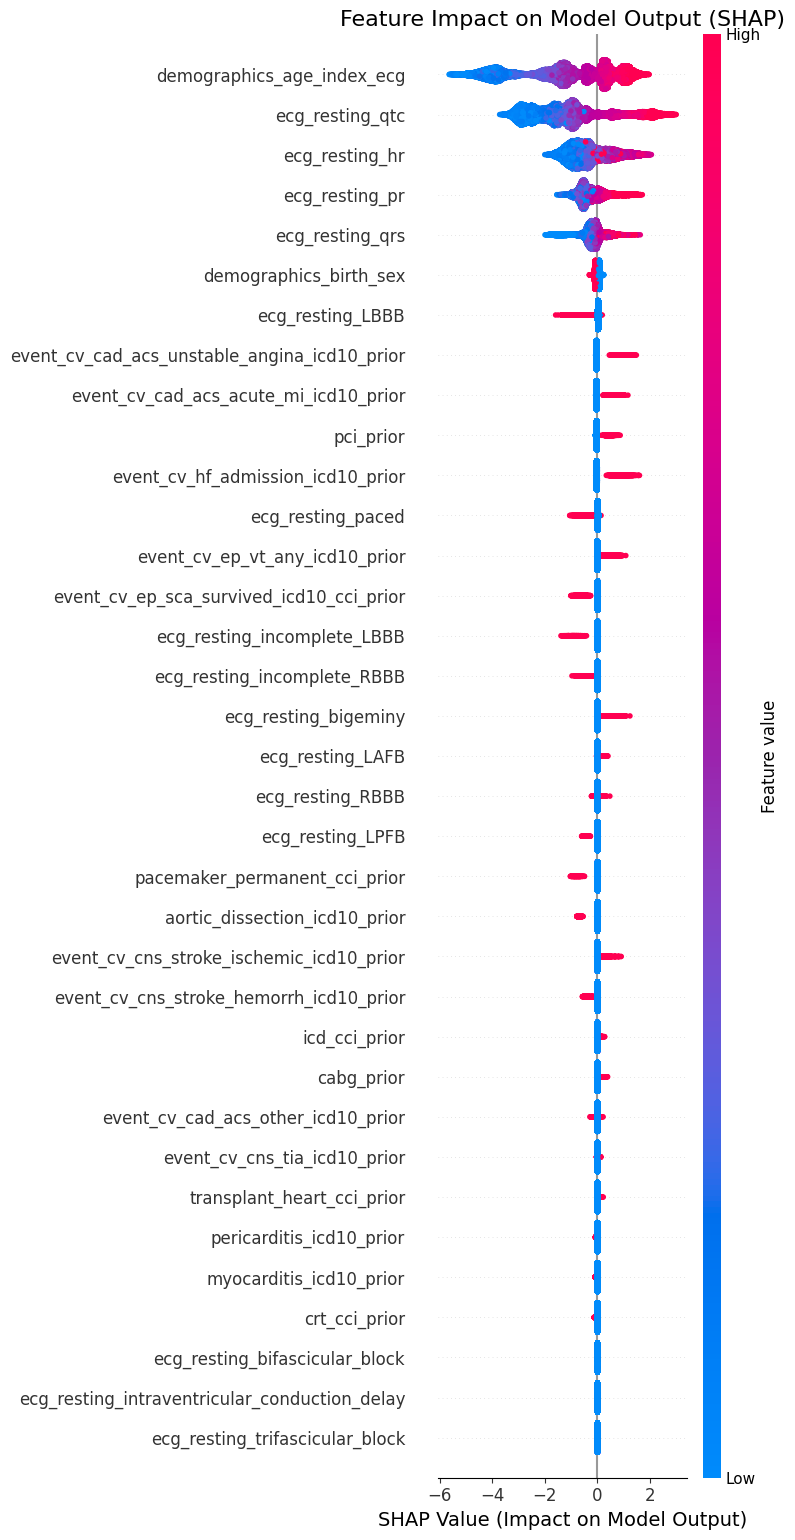

In [13]:
plt.figure(figsize=(12, 8))

shap.summary_plot(
    shap_values,
    X_train_scaled,
    max_display=35,
    show=False
)

plt.title("Feature Impact on Model Output (SHAP)", fontsize=16)
plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("shap.png", dpi=300, bbox_inches='tight')
plt.show()

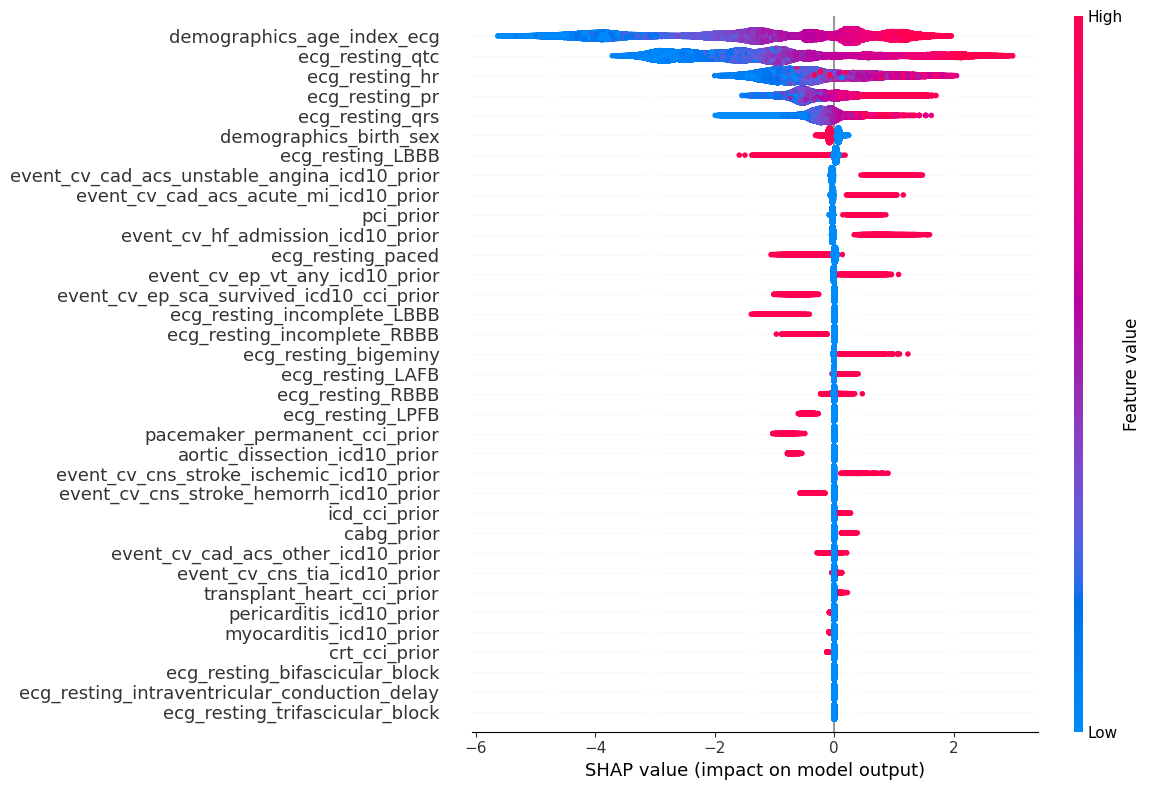

In [15]:
# let SHAP make its figure, but don't show it yet
shap.summary_plot(
    shap_values,
    X_train_scaled,
    max_display=35,
    show=False
)

# get the current figure (the one SHAP just drew onto)
fig = plt.gcf()
fig.set_size_inches(12, 8)
fig.tight_layout()
fig.savefig("shap.png", dpi=300, bbox_inches='tight')
plt.show()

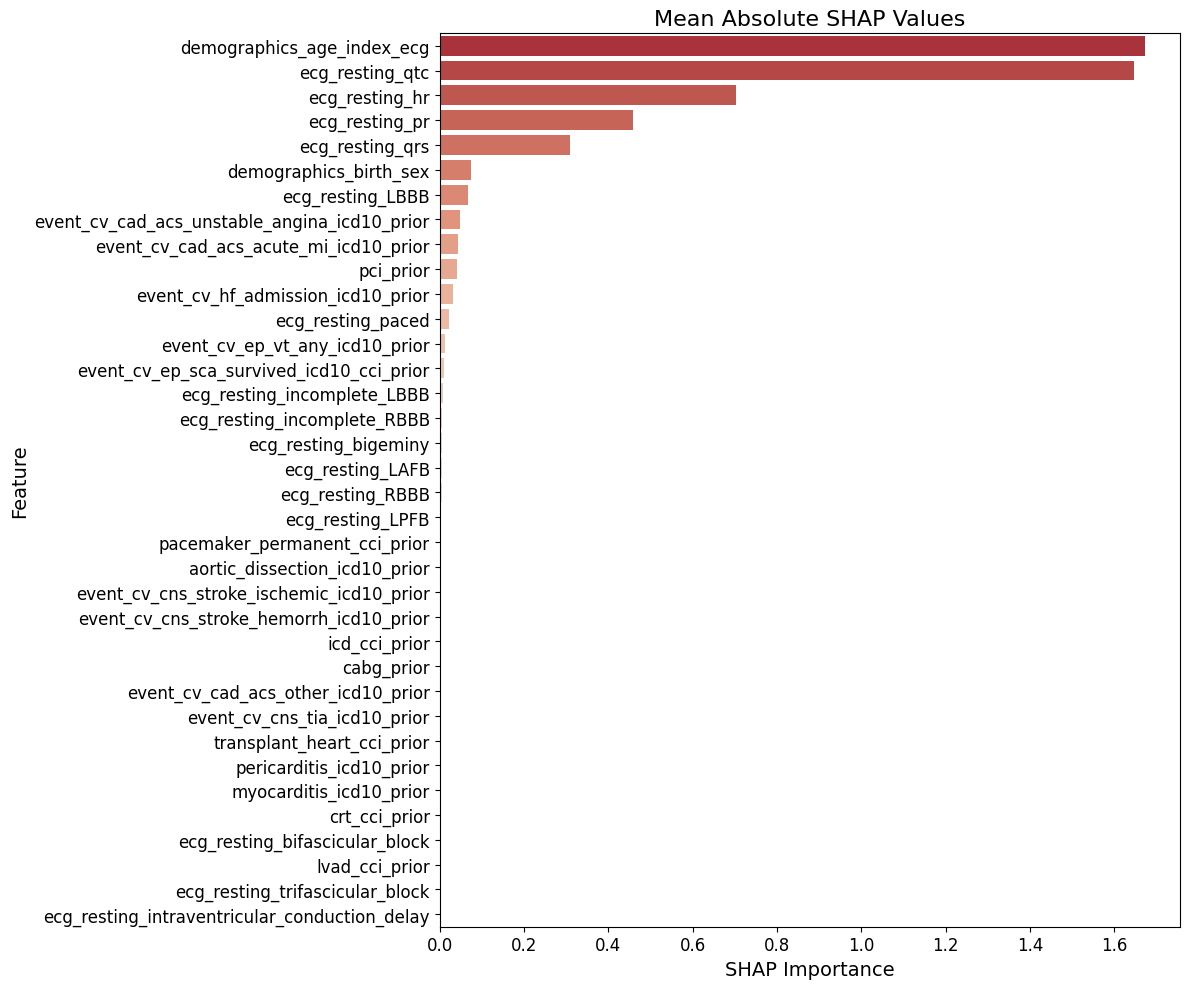

In [16]:
shap_df_sorted = shap_df.sort_values(by='mean_abs_shap', ascending=False)

plt.figure(figsize=(12, 10))

palette = sns.color_palette("coolwarm", len(shap_df_sorted))[::-1]
sns.barplot(
    x="mean_abs_shap",
    y="feature",
    hue="feature",
    data=shap_df_sorted,
    palette=palette,
    dodge=False,
    legend=False
)

plt.title("Mean Absolute SHAP Values", fontsize=16)
plt.xlabel("SHAP Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("shap-vals.png", dpi=300, bbox_inches='tight')
plt.show()

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin

class PreprocessDataTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        if "patient_id" in X.columns:
            X = X.drop(columns=["patient_id"])
        return X     

In [18]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline(steps=[
    ('preprocess_data', PreprocessDataTransformer()),
    ('imputer', IterativeImputer(random_state=26)),
    ('scaler', StandardScaler()),
    ('rf', best_xgb)
])
pipeline.fit(X_train, y_train)

import joblib
joblib.dump(pipeline, 'model.pkl')

['model.pkl']

ROC-AUC: 0.9710022617528464
PR-AUC: 0.7778124332542784
Recall: 0.8974111282843895
F1 Score: 0.5919082510353616
Confusion Matrix:
 [[74094  5874]
 [  531  4645]]


<Figure size 800x600 with 0 Axes>

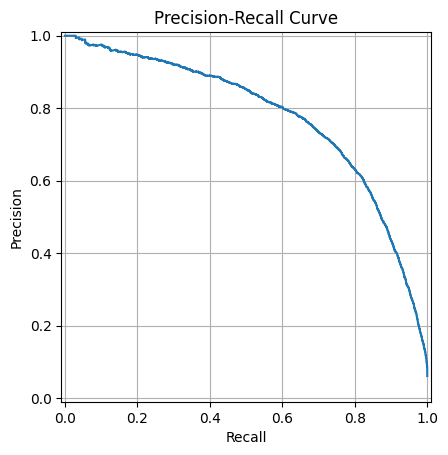

In [19]:
# ------------------------------
# Classification Evaluation
# ------------------------------
y_proba = cross_val_predict(best_xgb, X_train_scaled, y_train, cv=cv, method='predict_proba')[:, 1]
y_pred = (y_proba > 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_train, y_proba))
print("PR-AUC:", average_precision_score(y_train, y_proba))
print("Recall:", recall_score(y_train, y_pred))
print("F1 Score:", f1_score(y_train, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred))

precision, recall, _ = precision_recall_curve(y_train, y_proba)
plt.figure(figsize=(8, 6))
PrecisionRecallDisplay(precision=precision, recall=recall).plot()
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()

In [20]:
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    precision_recall_curve,
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay
)
import matplotlib.pyplot as plt

# ------------------------------
# Evaluate on Test Set
# ------------------------------
y_test_proba = best_xgb.predict_proba(X_test_scaled)[:, 1]
y_test_pred = (y_test_proba > 0.5).astype(int)

print("\n--- Test Set Evaluation ---")
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba))
print("PR-AUC:", average_precision_score(y_test, y_test_proba))
print("Recall:", recall_score(y_test, y_test_pred))
print("F1 Score:", f1_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


--- Test Set Evaluation ---
ROC-AUC: 0.9697014431738692
PR-AUC: 0.7650088020966623
Recall: 0.8894899536321483
F1 Score: 0.5773764735390018
Confusion Matrix:
 [[18450  1542]
 [  143  1151]]


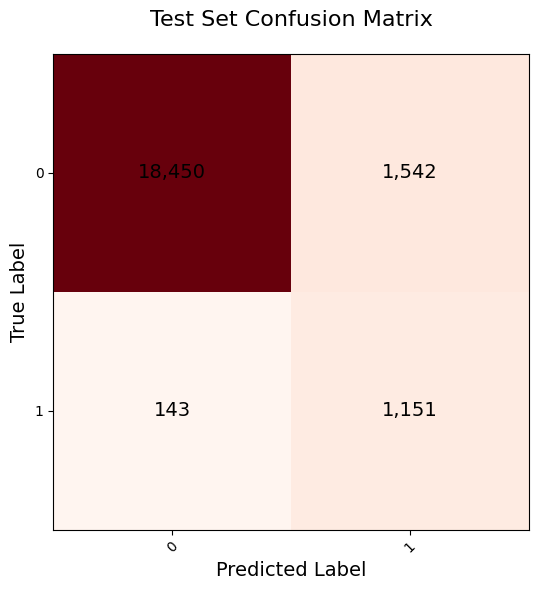

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- Compute Confusion Matrix ---
cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=best_xgb.classes_)

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Reds',
          colorbar=False,
          ax=ax,
          xticks_rotation=45)

# --- Add commas to the count annotations ---
for text in disp.text_.ravel():
    count = int(text.get_text())
    text.set_text(f"{count:,}")
    text.set_fontsize(14)
    text.set_color('black')

# --- Aesthetic tweaks ---
ax.set_title("Test Set Confusion Matrix", fontsize=16, pad=20)
ax.set_xlabel("Predicted Label", fontsize=14)
ax.set_ylabel("True Label", fontsize=14)
ax.grid(False)
plt.tight_layout()
plt.savefig("test-confusion-matrix.png", dpi=300, bbox_inches='tight')
plt.show()


<Figure size 800x600 with 0 Axes>

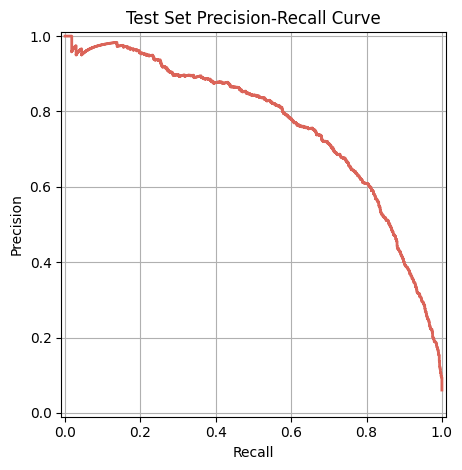

In [24]:
# --- Plot Precision-Recall Curve ---
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
plt.figure(figsize=(8, 6))
PrecisionRecallDisplay(precision=precision,
                       recall=recall).plot(color="#db6459", linewidth=2)
plt.title("Test Set Precision-Recall Curve")
plt.grid(True)
plt.tight_layout()
plt.savefig("test-precision-recall.png", dpi=300, bbox_inches='tight')
plt.show()

In [25]:
from sklearn.metrics import accuracy_score

weighted_accuracy = accuracy_score(y_test, y_test_pred)
print("Weighted Accuracy:", weighted_accuracy)

Weighted Accuracy: 0.9208399887249835


In [26]:
# Survival Analysis
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines.utils import concordance_index
from xgbse import XGBSEBootstrapEstimator
from xgbse.converters import convert_to_structured

In [27]:
data = pd.read_excel("synthetic_data_stats_competition_2025.xlsx")
data.shape

(106747, 138)

In [28]:
data = drop_missing_ECG(data)
data.shape

(106430, 138)

In [29]:
data["demographics_birth_sex"] = data["demographics_birth_sex"].replace({1: 0, 2: 1})
data["demographics_birth_sex"].head()

0    1
1    0
2    0
3    0
4    1
Name: demographics_birth_sex, dtype: int64

In [30]:
# ------------------------------
# Survival Targets
# ------------------------------
data["event"] = data["outcome_afib_aflutter_new_post"]

data["duration"] = data[[
    "time_to_outcome_afib_aflutter_new_post",
    "time_to_outcome_all_cause_death",
    "follow_up_duration"
]].min(axis=1)

# Drop rows with event = 1 but missing AF time
invalid_rows = (data["event"] == 1) & (data["time_to_outcome_afib_aflutter_new_post"].isna())
print(f"Dropping {invalid_rows.sum()} rows with event = 1 but no AF time.")
data = data[~invalid_rows]

data.shape

Dropping 0 rows with event = 1 but no AF time.


(106430, 140)

In [31]:
data.head()

,patient_id,demographics_age_index_ecg,demographics_birth_sex,hypertension_icd10,diabetes_combined,dyslipidemia_combined,dcm_icd10,hcm_icd10,myocarditis_icd10_prior,pericarditis_icd10_prior,...,glucose_ohg_other_peri,smoking_cessation_oral_peri,smoking_cessation_nicotine_replacement_peri,outcome_afib_aflutter_new_post,time_to_outcome_afib_aflutter_new_post,outcome_all_cause_death,time_to_outcome_all_cause_death,follow_up_duration,event,duration
0,000XpPEDHZ,51,1,0,0,1,0,0,0,0,...,0,0,0,0,NaN,0,NaN,849,0,849.0
1,0089QvLYpD,64,0,0,0,1,0,0,0,0,...,0,0,0,0,NaN,1,1187.0,1187,0,1187.0
2,009OdzZUzb,61,0,0,0,1,0,0,0,0,...,0,0,0,0,NaN,0,NaN,5297,0,5297.0
3,00AkCj8EF2,46,0,0,0,1,0,0,0,0,...,0,0,0,0,NaN,0,NaN,3465,0,3465.0
4,00CBjJ6vTV,75,1,0,0,0,0,0,0,0,...,0,0,0,0,NaN,1,2082.0,2082,0,2082.0


In [32]:
selected_features = X_train_scaled.columns.tolist()
selected_features

['demographics_age_index_ecg',
 'demographics_birth_sex',
 'myocarditis_icd10_prior',
 'pericarditis_icd10_prior',
 'aortic_dissection_icd10_prior',
 'event_cv_hf_admission_icd10_prior',
 'event_cv_cad_acs_acute_mi_icd10_prior',
 'event_cv_cad_acs_unstable_angina_icd10_prior',
 'event_cv_cad_acs_other_icd10_prior',
 'event_cv_ep_vt_any_icd10_prior',
 'event_cv_ep_sca_survived_icd10_cci_prior',
 'event_cv_cns_stroke_ischemic_icd10_prior',
 'event_cv_cns_stroke_hemorrh_icd10_prior',
 'event_cv_cns_tia_icd10_prior',
 'pci_prior',
 'cabg_prior',
 'transplant_heart_cci_prior',
 'lvad_cci_prior',
 'pacemaker_permanent_cci_prior',
 'crt_cci_prior',
 'icd_cci_prior',
 'ecg_resting_hr',
 'ecg_resting_pr',
 'ecg_resting_qrs',
 'ecg_resting_qtc',
 'ecg_resting_paced',
 'ecg_resting_bigeminy',
 'ecg_resting_LBBB',
 'ecg_resting_RBBB',
 'ecg_resting_incomplete_LBBB',
 'ecg_resting_incomplete_RBBB',
 'ecg_resting_LAFB',
 'ecg_resting_LPFB',
 'ecg_resting_bifascicular_block',
 'ecg_resting_trifascicu

In [33]:
X = data[selected_features].copy()
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 106430 entries, 0 to 106746
Data columns (total 36 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   demographics_age_index_ecg                     106430 non-null  int64  
 1   demographics_birth_sex                         106430 non-null  int64  
 2   myocarditis_icd10_prior                        106430 non-null  int64  
 3   pericarditis_icd10_prior                       106430 non-null  int64  
 4   aortic_dissection_icd10_prior                  106430 non-null  int64  
 5   event_cv_hf_admission_icd10_prior              106430 non-null  int64  
 6   event_cv_cad_acs_acute_mi_icd10_prior          106430 non-null  int64  
 7   event_cv_cad_acs_unstable_angina_icd10_prior   106430 non-null  int64  
 8   event_cv_cad_acs_other_icd10_prior             106430 non-null  int64  
 9   event_cv_ep_vt_any_icd10_prior            

In [34]:
mice_imputer = IterativeImputer(random_state=26)
scaler = StandardScaler()

X_imputed = pd.DataFrame(mice_imputer.fit_transform(X),
                         columns=selected_features)

X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed),
                        columns=selected_features)

In [35]:
data_scaled = X_scaled.copy()
data_scaled["duration"] = data["duration"].values
data_scaled["event"] = data["event"].values
data_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106430 entries, 0 to 106429
Data columns (total 38 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   demographics_age_index_ecg                     106430 non-null  float64
 1   demographics_birth_sex                         106430 non-null  float64
 2   myocarditis_icd10_prior                        106430 non-null  float64
 3   pericarditis_icd10_prior                       106430 non-null  float64
 4   aortic_dissection_icd10_prior                  106430 non-null  float64
 5   event_cv_hf_admission_icd10_prior              106430 non-null  float64
 6   event_cv_cad_acs_acute_mi_icd10_prior          106430 non-null  float64
 7   event_cv_cad_acs_unstable_angina_icd10_prior   106430 non-null  float64
 8   event_cv_cad_acs_other_icd10_prior             106430 non-null  float64
 9   event_cv_ep_vt_any_icd10_prior       

In [36]:
data_scaled.head()

,demographics_age_index_ecg,demographics_birth_sex,myocarditis_icd10_prior,pericarditis_icd10_prior,aortic_dissection_icd10_prior,event_cv_hf_admission_icd10_prior,event_cv_cad_acs_acute_mi_icd10_prior,event_cv_cad_acs_unstable_angina_icd10_prior,event_cv_cad_acs_other_icd10_prior,event_cv_ep_vt_any_icd10_prior,...,ecg_resting_RBBB,ecg_resting_incomplete_LBBB,ecg_resting_incomplete_RBBB,ecg_resting_LAFB,ecg_resting_LPFB,ecg_resting_bifascicular_block,ecg_resting_trifascicular_block,ecg_resting_intraventricular_conduction_delay,duration,event
0,-0.250456,0.970190,-0.046028,-0.054484,-0.052361,-0.107416,-0.147027,-0.133551,-0.091047,-0.089673,...,-0.142322,-0.063468,-0.086422,-0.10875,-0.068496,-0.018395,-0.025837,-0.015632,849.0,0
1,0.867001,-1.030726,-0.046028,-0.054484,-0.052361,-0.107416,-0.147027,-0.133551,-0.091047,-0.089673,...,-0.142322,-0.063468,-0.086422,-0.10875,-0.068496,-0.018395,-0.025837,-0.015632,1187.0,0
2,0.609126,-1.030726,-0.046028,-0.054484,-0.052361,-0.107416,-0.147027,-0.133551,-0.091047,-0.089673,...,-0.142322,-0.063468,-0.086422,-0.10875,-0.068496,-0.018395,-0.025837,-0.015632,5297.0,0
3,-0.680248,-1.030726,-0.046028,-0.054484,-0.052361,-0.107416,-0.147027,-0.133551,-0.091047,-0.089673,...,-0.142322,-0.063468,-0.086422,-0.10875,-0.068496,-0.018395,-0.025837,-0.015632,3465.0,0
4,1.812541,0.970190,-0.046028,-0.054484,-0.052361,-0.107416,-0.147027,-0.133551,-0.091047,-0.089673,...,-0.142322,-0.063468,-0.086422,-0.10875,-0.068496,-0.018395,-0.025837,-0.015632,2082.0,0


In [37]:
X = data_scaled.drop(columns=["duration", "event"])
y_time = data_scaled["duration"]
y_event = data_scaled["event"]

In [38]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106430 entries, 0 to 106429
Data columns (total 36 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   demographics_age_index_ecg                     106430 non-null  float64
 1   demographics_birth_sex                         106430 non-null  float64
 2   myocarditis_icd10_prior                        106430 non-null  float64
 3   pericarditis_icd10_prior                       106430 non-null  float64
 4   aortic_dissection_icd10_prior                  106430 non-null  float64
 5   event_cv_hf_admission_icd10_prior              106430 non-null  float64
 6   event_cv_cad_acs_acute_mi_icd10_prior          106430 non-null  float64
 7   event_cv_cad_acs_unstable_angina_icd10_prior   106430 non-null  float64
 8   event_cv_cad_acs_other_icd10_prior             106430 non-null  float64
 9   event_cv_ep_vt_any_icd10_prior       

In [39]:
y_time.info()
y_event.info()

<class 'pandas.core.series.Series'>
RangeIndex: 106430 entries, 0 to 106429
Series name: duration
Non-Null Count   Dtype  
--------------   -----  
106430 non-null  float64
dtypes: float64(1)
memory usage: 831.6 KB
<class 'pandas.core.series.Series'>
RangeIndex: 106430 entries, 0 to 106429
Series name: event
Non-Null Count   Dtype
--------------   -----
106430 non-null  int64
dtypes: int64(1)
memory usage: 831.6 KB


In [40]:
penalizers = [0.001, 0.01, 0.1, 1, 10]

In [41]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=26)

In [42]:
mean_c_indices = {}
for p in penalizers:
    c_indices = []
    for train_idx, test_idx in skf.split(X, y_event):
        train_df = data_scaled.iloc[train_idx]
        test_df  = data_scaled.iloc[test_idx]

        # Fit Cox model with current penalizer
        cph = CoxPHFitter(penalizer=p)
        cph.fit(train_df, duration_col="duration", event_col="event")

        # Compute c-index on the test fold
        ph = cph.predict_partial_hazard(test_df)
        ci = concordance_index(
            test_df["duration"],
            -ph, 
            test_df["event"]
        )
        c_indices.append(ci)

    mean_c_indices[p] = np.mean(c_indices)
    print(f"Penalizer={p:<6} → Mean c-index={mean_c_indices[p]:.4f}")

Penalizer=0.001  → Mean c-index=0.8989
Penalizer=0.01   → Mean c-index=0.9384
Penalizer=0.1    → Mean c-index=0.9326
Penalizer=1      → Mean c-index=0.9158
Penalizer=10     → Mean c-index=0.9128


In [43]:
best_p = max(mean_c_indices, key=mean_c_indices.get)
print(f"Best penalizer: {best_p} (c-index={mean_c_indices[best_p]:.4f})")

Best penalizer: 0.01 (c-index=0.9384)


In [44]:
# Refit final model with best_p
best_cox = CoxPHFitter(penalizer=best_p)
best_cox.fit(data_scaled, duration_col="duration", event_col="event")
best_cox.print_summary()

<lifelines.CoxPHFitter: fitted with 106430 total observations, 99960 right-censored observations>
             duration col = 'duration'
                event col = 'event'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 106430
number of events observed = 6470
   partial log-likelihood = -61802.67
         time fit was run = 2025-05-15 07:25:56 UTC

---
                                                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                             
demographics_age_index_ecg                      0.92       2.50       0.02             0.89             0.95                 2.43                 2.58
demographics_birth_sex                         -0.08       0.92       0.01            -0.10            -0.06                 0.90                 0.94
myocarditis_icd10_prior                        -0.00       1.00       0.01            -0.03             0.02                 0.97                 1.02
pericarditis_icd10_prior                       -0.03       0.97       0.01            -0.05            -0.01                 0.95                 0.99
aortic_dissection_icd10_prior                  -0.03       0.97       0.02            -0.06             0.01                 0.94                 1.01
event_cv_hf_admission_icd10_prior               0.05       1.05       0.01             0.04             0.07                 1.04                 1.07
event_cv_cad_acs_acute_mi_icd10_prior           0.05       1.05       0.01             0.03             0.07                 1.03                 1.07
event_cv_cad_acs_unstable_angina_icd10_prior    0.05       1.05       0.01             0.04             0.06                 1.04                 1.07
event_cv_cad_acs_other_icd10_prior              0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
event_cv_ep_vt_any_icd10_prior                  0.05       1.05       0.01             0.03             0.07                 1.03                 1.07
event_cv_ep_sca_survived_icd10_cci_prior       -0.06       0.95       0.01            -0.08            -0.03                 0.92                 0.97
event_cv_cns_stroke_ischemic_icd10_prior       -0.00       1.00       0.01            -0.03             0.02                 0.97                 1.02
event_cv_cns_stroke_hemorrh_icd10_prior        -0.02       0.98       0.02            -0.05             0.01                 0.95                 1.01
event_cv_cns_tia_icd10_prior                    0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
pci_prior                                       0.03       1.03       0.01             0.01             0.05                 1.01                 1.05
cabg_prior                                     -0.04       0.96       0.01            -0.05            -0.03                 0.95                 0.97
transplant_heart_cci_prior                      0.01       1.01       0.01            -0.01             0.03                 0.99                 1.04
lvad_cci_prior                                 -0.03       0.98       0.02            -0.07             0.02                 0.94                 1.02
pacemaker_permanent_cci_prior                  -0.03       0.97       0.01            -0.06            -0.01                 0.95                 0.99
crt_cci_prior                                  -0.04       0.96       0.02            -0.08             0.00                 0.92                 1.00
icd_cci_prior                                   0.04       1.04       0.01             0.02             0.06                 1.03                 1.06
ecg_resting_hr                                  0.35       1.43       0.01             0.3

In [45]:
data_scaled["risk"] = best_cox.predict_partial_hazard(data_scaled)
data_scaled["risk"].describe()

count    106430.000000
mean          3.335583
std          16.864786
min           0.004334
25%           0.375534
50%           0.930760
75%           2.383897
max        1725.509911
Name: risk, dtype: float64

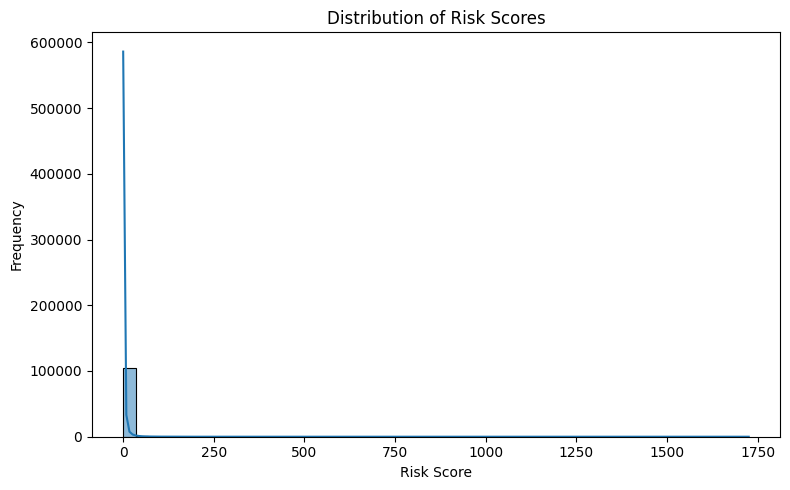

In [46]:
plt.figure(figsize=(8, 5))
sns.histplot(data_scaled["risk"], bins=50, kde=True)
plt.title("Distribution of Risk Scores")
plt.xlabel("Risk Score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [47]:
# Log-transform risk to reduce skew, log(1 + risk)
data_scaled["log_risk"] = np.log1p(data_scaled["risk"])
data_scaled["log_risk"].describe()

count    106430.000000
mean          0.891762
std           0.790078
min           0.004325
25%           0.318842
50%           0.657914
75%           1.219028
max           7.453857
Name: log_risk, dtype: float64

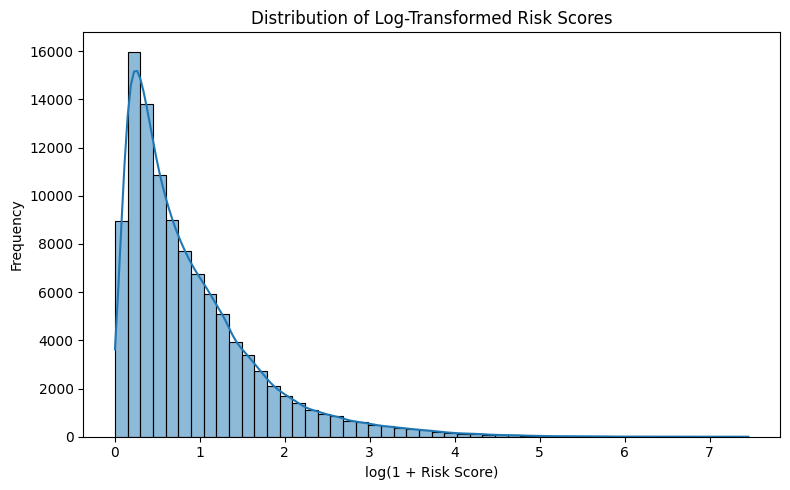

In [48]:
plt.figure(figsize=(8, 5))
sns.histplot(data_scaled["log_risk"], bins=50, kde=True)
plt.title("Distribution of Log-Transformed Risk Scores")
plt.xlabel("log(1 + Risk Score)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [49]:
# ------------------------------
# Risk Stratification by Median
# ------------------------------
median_risk = data_scaled["log_risk"].median()

data_scaled["risk_group"] = np.where(
    data_scaled["log_risk"] >= median_risk, "High", "Low"
)

# Filter just the two groups
df_km = data_scaled[data_scaled["risk_group"].isin(["Low", "High"])].copy()

# Check event counts
event_counts = df_km.groupby("risk_group")["event"].sum().astype(int)
print("\nEvent counts per risk group:")
print(event_counts)


Event counts per risk group:
risk_group
High    6427
Low       43
Name: event, dtype: int64


The High-risk group had 6,427 events, while the Low-risk group had 43. This reflects a meaningful separation between groups, while still retaining enough events in the Low group for statistical comparison — a good balance of interpretability and power.

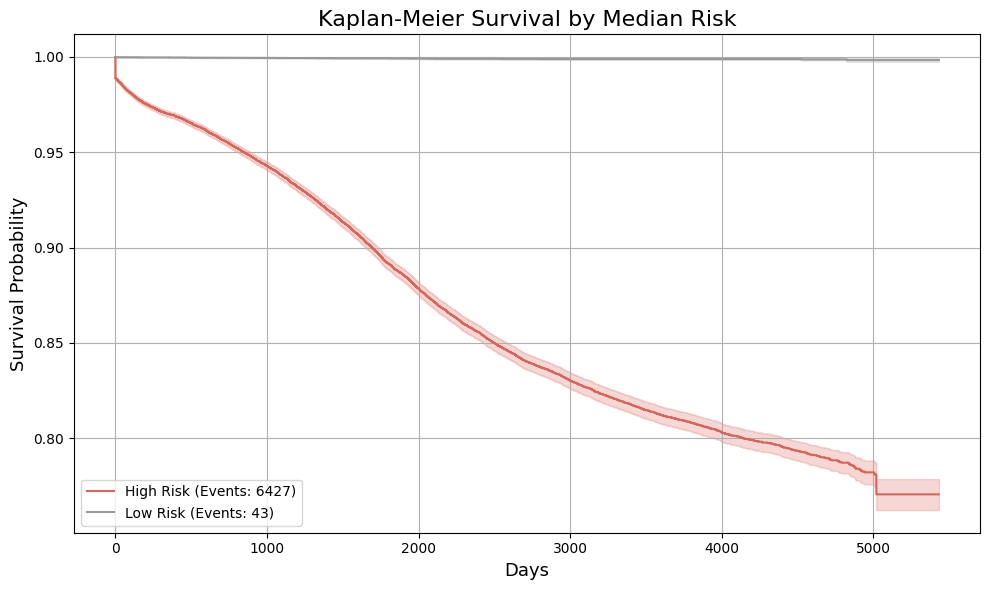

<Figure size 640x480 with 0 Axes>

In [50]:
# ------------------------------
# Kaplan-Meier Plot
# ------------------------------
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import seaborn as sns

kmf = KaplanMeierFitter()

custom_colors = {
    "High": "#db6459",
    "Low": "#989898"
}

plt.figure(figsize=(10, 6))

for group in ["High", "Low"]:
    label = f"{group} Risk (Events: {event_counts.get(group, 0)})"
    kmf.fit(
        durations=df_km[df_km["risk_group"] == group]["duration"],
        event_observed=df_km[df_km["risk_group"] == group]["event"],
        label=label
    )
    kmf.plot_survival_function(ci_show=True, color=custom_colors.get(group))

plt.title("Kaplan-Meier Survival by Median Risk", fontsize=16)
plt.xlabel("Days", fontsize=13)
plt.ylabel("Survival Probability", fontsize=13)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig("kaplan-meier-survival.png", dpi=300, bbox_inches='tight')

The survival curves show clear divergence. Individuals in the Low-risk group consistently demonstrate better survival over time, confirming effective risk stratification based on the Cox model.

In [51]:
# ------------------------------------------
# Log-rank Test (Statistical Difference)
# ------------------------------------------
from lifelines.statistics import logrank_test

results = logrank_test(
    df_km[df_km["risk_group"] == "High"]["duration"],
    df_km[df_km["risk_group"] == "Low"]["duration"],
    event_observed_A=df_km[df_km["risk_group"] == "High"]["event"],
    event_observed_B=df_km[df_km["risk_group"] == "Low"]["event"]
)

print("Log-rank Test Result:")
print(results.summary)

Log-rank Test Result:
   test_statistic    p  -log2(p)
0     7337.919739  0.0       inf


The statistical test yielded a very large test statistic and a p-value near zero, indicating that the survival difference between the High and Low groups is highly significant and unlikely due to chance.